# QAQC testbed

This workbook is under development, but will inform the quality assurance and quality control of CIHP products.

## module load, parameter definitions, etc

In [1]:
import xarray as xr
import geopandas as gp
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import numpy as np
import os
import json
#import sys
from collections import defaultdict
#import nc_time_axis
import matplotlib.dates as mdates
import cftime
from dask.diagnostics import ProgressBar

In [2]:
model_list = ['ACCESS1-0', 'CanESM2', 'CESM1-CAM5', 'CNRM-CM5', 'GFDL-ESM2M', 'HadGEM2-CC', 'MIROC5', 'NorESM1-M']
region_list = ['AUS','NSW1','NSW2','NSW3','NT1','NT2','QLD1','QLD2','QLD3','SA1','SA2','SAMPLE','TAS1','VIC1','VIC2','WA1','WA2','WA3']
variable_list = ['pr','rhs','rsds','tasmax','tasmin']
scenario_list = ['rcp26','rcp45','rcp85']
timerange_list=['2016-2045','2036-2065','2056-2085']

In [3]:
region_bounds = {
    'AUS'  :[-10.3,155,-44.5,112],
    'TAS1':[-39.5,149.85,-44.5,142.15],
    'VIC1':[-33.95,144.25,-39,140.9],
    'VIC2':[-35.65,150,-39.25,144.25],
    'NSW1':[-28.9,147.65,-36.25,140.9],
    'NSW2':[-28.1,153.75,-32.45,147.65],
    'NSW3':[-32.45,153.3,-37.7,147.65],
    'QLD1':[-23.85,153.75,-29.3,137.9],
    'QLD2':[-8.9,144.4,-23.85,137.9],
    'QLD3':[-13.95,151.5,-23.85,144.4],
    'NT1' :[-10.6,138.15,-19.7,128.9],
    'NT2' :[-19.7,138.15,-26.05,128.9],
    'WA1' :[-13.6,129.1,-23.85,113.1],
    'WA2' :[-23.85,129.1,-35.4,117.85],
    'WA3' :[-23.85,117.85,-35.4,112.85],
    'SA1' :[-25.95,141.05,-38.45,135.5],
    'SA2' :[-25.95,135.5,-35.15,132.65],
    'SAMPLE':[-31.15,134.65,-33.15,132.65]
}

In [4]:
# put the below within a if __name__=='__main__' block if current as script
import dask.distributed as dsk

# Start client
clnt = dsk.Client()
clnt

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 2
Total threads: 2,Total memory: 9.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35041,Workers: 2
Dashboard: /proxy/8787/status,Total threads: 2
Started: Just now,Total memory: 9.00 GiB
Comm: tcp://127.0.0.1:39797,Total threads: 1
Dashboard: /proxy/38045/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:42037,


## File existence checks

This will check the files that exist against those that should exist if all files fit the given data reference syntax (DRS). The DRS suggests seperate folders within the /g/data/wp00/data/QQ-CMIP5/AgDataShop/ directory for each CIHP-1 subproduct available on the Ag Data Shop. These will be:
- AUS_averages (temporal averages for the whole AUS domain)
- SAMPLE_averages (temporal averages for the sample region)
- {region}_daily (daily data for each region)

where the regions are AUS, SAMPLE, NSW1, NSW2, NSW3, NT1, NT2, QLD1, QLD2, QLD3, SA1, SA2, TAS1, VIC1, VIC2, WA1, WA2 and WA3. Boundaries for these regions can be found on the confluence page, and are in the region_bounds dictionary defined above in this code.

The DRS will have each file within the directories named as:

{variable}\_{model}\_{scenario}\_r1i1p1_CSIRO-QQS-AGCD-1981-2010_day_wrt_1986-2005_{period}-{agglom}-mean_g-{region}.nc

where the following are appropriate for each field:
- {variable}: ['pr', 'rhs', 'rsds', 'tasmax', 'tasmin']
- {model}: ['ACCESS1-0', 'CanESM2', 'CESM1-CAM5', 'CNRM-CM5', 'GFDL-ESM2M', 'HadGEM2-CC', 'MIROC5', 'NorESM1-M']
- {scenario}: ['rcp26', 'rcp45', 'rcp85']
- {period}: ['2016-2045', '2036-2065', '2056-2085']
- {agglom}: ['daily', 'monthly', 'seasonal', 'annual']
- {region}: ['AUS','NSW1','NSW2','NSW3','NT1','NT2','QLD1','QLD2','QLD3','SA1','SA2','SAMPLE','TAS1','VIC1','VIC2','WA1','WA2','WA3']

Only files that *don't* exist against this DRS schema will be outputted at the end of this section.

In [7]:
# region=region_list[1]
# variable=variable_list[0]
# model=model_list[0]
# scenario=scenario_list[0]
# period=timerange_list[0]
# file_list = [f"/g/data/wp00/data/QQ-CMIP5/AgDataShop/{region}_daily/{variable}_{model}_{scenario}_r1i1p1_CSIRO-QQS-ERA5-1981-2010_day_wrt_1986-2005_{period}-daily-mean.nc"
#              if variable in ['rhs','rsds'] else f"/g/data/wp00/data/QQ-CMIP5/AgDataShop/{region}_daily/{variable}_{model}_{scenario}_r1i1p1_CSIRO-QQS-AGCD-1981-2010_day_wrt_1986-2005_{period}-daily-mean.nc"
#                 for scenario in ['rcp26','rcp45','rcp85'] 
#                 for region in ['AUS']
#                 for variable in ['tasmax'] 
#                 for model in model_list 
#                 for period in timerange_list]

# file_list = [f"/scratch/wp00/mjk563/{variable}_{model}_{scenario}_r1i1p1_CSIRO-QQS-ERA5-1981-2010_day_wrt_1986-2005_{period}-daily-mean_g-{region}.nc"
#              if variable in ['rhs','rsds'] else f"/scratch/wp00/mjk563/{variable}_{model}_{scenario}_r1i1p1_CSIRO-QQS-AGCD-1981-2010_day_wrt_1986-2005_{period}-daily-mean_g-{region}.nc"
#                 for scenario in ['rcp85'] 
#                 for region in ['NSW3']
#                 for variable in ['rhs'] 
#                 for model in ['GFDL-ESM2M', 'HadGEM2-CC', 'MIROC5', 'NorESM1-M'] 
#                 for period in ['2056-2085']]

# file_list = [f"/g/data/wp00/data/QQ-CMIP5/AgDataShop/{region}_daily/{variable}_{model}_{scenario}_r1i1p1_CSIRO-QQS-ERA5-1981-2010_day_wrt_1986-2005_{period}-daily-mean_g-{region}.nc"
#              if variable in ['rhs','rsds'] else f"/g/data/wp00/data/QQ-CMIP5/AgDataShop/{region}_daily/{variable}_{model}_{scenario}_r1i1p1_CSIRO-QQS-AGCD-1981-2010_day_wrt_1986-2005_{period}-daily-mean_g-{region}.nc"
#                 for scenario in ['rcp26','rcp45','rcp85'] 
#                 for region in ['TAS1']
#                 for variable in variable_list 
#                 for model in model_list 
#                 for period in timerange_list]

file_list = [f"/g/data/wp00/data/QQ-CMIP5/AgDataShop/{region}_averages/{variable}_{model}_{scenario}_r1i1p1_CSIRO-QQS-ERA5-1981-2010_day_wrt_1986-2005_{period}-{accum}-mean.nc"
             if variable in ['rhs','rsds'] else f"/g/data/wp00/data/QQ-CMIP5/AgDataShop/{region}_averages/{variable}_{model}_{scenario}_r1i1p1_CSIRO-QQS-AGCD-1981-2010_day_wrt_1986-2005_{period}-{accum}-mean.nc"
                for scenario in ['rcp26','rcp45','rcp85'] 
                for region in ['AUS']
                for variable in ['tasmax'] 
                for model in model_list 
                for period in timerange_list
                for accum in ['monthly']]

In [8]:
nofile_list=[file for file in file_list if not os.path.exists(file)]
nofile_list.sort()
nofile_list

['/g/data/wp00/data/QQ-CMIP5/AgDataShop/AUS_averages/tasmax_ACCESS1-0_rcp26_r1i1p1_CSIRO-QQS-AGCD-1981-2010_day_wrt_1986-2005_2016-2045-monthly-mean.nc',
 '/g/data/wp00/data/QQ-CMIP5/AgDataShop/AUS_averages/tasmax_ACCESS1-0_rcp26_r1i1p1_CSIRO-QQS-AGCD-1981-2010_day_wrt_1986-2005_2036-2065-monthly-mean.nc',
 '/g/data/wp00/data/QQ-CMIP5/AgDataShop/AUS_averages/tasmax_ACCESS1-0_rcp26_r1i1p1_CSIRO-QQS-AGCD-1981-2010_day_wrt_1986-2005_2056-2085-monthly-mean.nc',
 '/g/data/wp00/data/QQ-CMIP5/AgDataShop/AUS_averages/tasmax_CESM1-CAM5_rcp26_r1i1p1_CSIRO-QQS-AGCD-1981-2010_day_wrt_1986-2005_2036-2065-monthly-mean.nc',
 '/g/data/wp00/data/QQ-CMIP5/AgDataShop/AUS_averages/tasmax_HadGEM2-CC_rcp26_r1i1p1_CSIRO-QQS-AGCD-1981-2010_day_wrt_1986-2005_2016-2045-monthly-mean.nc',
 '/g/data/wp00/data/QQ-CMIP5/AgDataShop/AUS_averages/tasmax_HadGEM2-CC_rcp26_r1i1p1_CSIRO-QQS-AGCD-1981-2010_day_wrt_1986-2005_2036-2065-monthly-mean.nc',
 '/g/data/wp00/data/QQ-CMIP5/AgDataShop/AUS_averages/tasmax_HadGEM2-CC_rc

In [10]:
known_missing=['rhs_CESM1-CAM5','rsds_CESM1-CAM5','ACCESS1-0_rcp26','HadGEM2-CC_rcp26','rhs_CNRM-CM5_rcp26','rhs_GFDL-ESM2M_rcp26','rhs_MIROC5_rcp26','rhs_NorESM1-M_rcp26','tasmin_CESM1-CAM5_rcp26']
[file for file in nofile_list if not np.any(([k in file for k in known_missing]))]

['/g/data/wp00/data/QQ-CMIP5/AgDataShop/AUS_daily/tasmax_CESM1-CAM5_rcp26_r1i1p1_CSIRO-QQS-AGCD-1981-2010_day_wrt_1986-2005_2036-2065-daily-mean.nc']

## File structure and metadata checks

### dimension and field checks

This section checks that:
- each file has a time, lat and lon coordinate
- that their size and values match given by the period and region in the file name
- that the data variable matches that given in the file name
- that the data type (e.g. float, double, string) for each matches our desired type (float for data variables)

In [11]:
isfile_list=[file for file in file_list if os.path.exists(file)]
isfile_list.sort()
isfile_list

['/scratch/wp00/mjk563/rhs_GFDL-ESM2M_rcp85_r1i1p1_CSIRO-QQS-ERA5-1981-2010_day_wrt_1986-2005_2056-2085-daily-mean_g-NSW3.nc',
 '/scratch/wp00/mjk563/rhs_HadGEM2-CC_rcp85_r1i1p1_CSIRO-QQS-ERA5-1981-2010_day_wrt_1986-2005_2056-2085-daily-mean_g-NSW3.nc',
 '/scratch/wp00/mjk563/rhs_MIROC5_rcp85_r1i1p1_CSIRO-QQS-ERA5-1981-2010_day_wrt_1986-2005_2056-2085-daily-mean_g-NSW3.nc',
 '/scratch/wp00/mjk563/rhs_NorESM1-M_rcp85_r1i1p1_CSIRO-QQS-ERA5-1981-2010_day_wrt_1986-2005_2056-2085-daily-mean_g-NSW3.nc']

In [12]:
for filepath in isfile_list:
    try:
        dataset=xr.open_dataset(filepath)
        directory,splitchar,filename=filepath.rpartition('/')
        drs_variable=filename.split('_')[0]
        drs_startyear=filename.split('_')[8].split('-')[0]
        drs_endyear=filename.split('_')[8].split('-')[1]
        drs_accum=filename.split('_')[8].split('-')[2]
        try:
            drs_region=filename.split('_')[9].partition('-')[2].partition('.')[0]
        except:
            drs_region="AUS"
        if not drs_variable in (dataset.data_vars):
            print(filepath)
            print ("ERROR: data variable does not match file name, please check")
            
        if not (np.array([coord in dataset.coords for coord in ['time','lat','lon']]).all() or np.array([coord in dataset.coords for coord in ['time','latitude','longitude']]).all()):
            print(filepath)
            print ("ERROR: co-ordinates are missing, please check")
            
        # if not (dataset['time.year'][0]==int(drs_startyear) and dataset['time.month'][0]==1 and dataset['time.day'][0]==1):
        #     print (filename)
        #     print ("ERROR: start date does not match file name: ",drs_startyear)
            
        # if not (dataset['time.year'][-1]==int(drs_endyear) and dataset['time.month'][-1]==12 and dataset['time.day'][-1]==31):
        #     print (filename)
        #     print ("ERROR: end date does not match file name: ",drs_endyear)

        if not (dataset['time.year'][0]==int(drs_startyear)):
            print(filepath)
            print ("ERROR: start date does not match file name: ",drs_startyear)
            
        if not (dataset['time.year'][-1]==int(drs_endyear)):
            if drs_accum=='seasonal' and (dataset['time.year'][-1]==int(drs_endyear)+1):
                pass
            else:
                print(filepath)
                print ("ERROR: end date does not match file name: ",drs_endyear)
            
        if not dataset[drs_variable].dtype=='float32':
            print(filepath)
            print("ERROR: variable datatype incorrect, not single float")
            
        # if not (dataset['lat'].dtype=='float32' and dataset['lon'].dtype=='float32'):
        #     print (filename)
        #     print("ERROR: lat/lon datatype incorrect, not single float")
        
        # # A delta approach is used below here to account for the precision errors
        if dataset.lat.max()-region_bounds[drs_region][0]>.001 \
        or dataset.lon.max()-region_bounds[drs_region][1]>.001 \
        or dataset.lat.min()-region_bounds[drs_region][2]>.001 \
        or dataset.lon.min()-region_bounds[drs_region][3]>.001:
            print(filepath)
            print("ERROR: coordinates do not match region description, please investigate.")
    except OSError:
        directory,splitchar,filename=filepath.rpartition('/')
        print(filepath)
        print ("ERROR: HDF error raised with this file during load, check")
    except:
        print(filepath)
        print('something funky with time in this file')

0.3.0


### grid check

This checks if the timeseries and grid the data is saved on is evenly spaced: that is, the co-ordinate variables aren't missing any values as well as that the spacing of the data matches our desired grid (which is 0.05 degree spaced) and our daily temporal resolution.

In [27]:
for filepath in isfile_list:
    try:
        dataset=xr.open_dataset(filepath)
        directory,splitchar,filename=filepath.rpartition('/')
        print (filename)
        ok_flag=True
        if np.unique(dataset.lat.diff(dim='lat')).size>1:
            print('Latitude not evenly spaced, values: ',np.unique(dataset.lat.diff(dim='lat')))
            ok_flag=False
        if np.unique(dataset.lon.diff(dim='lon')).size>1:
            print('Longitude not evenly spaced, values: ',np.unique(dataset.lon.diff(dim='lon')))
            ok_flag=False
        if np.unique(dataset.time.diff(dim='time')).size>1:
            if np.isin([2419200000000000,2592000000000000,2678400000000000],np.unique(dataset.time.diff(dim='time'))).all():
                pass
            elif np.isin([7776000000000000,7862400000000000,7948800000000000],np.unique(dataset.time.diff(dim='time'))).all():
                pass
            else:
                print('Time dimension not evenly spaced, values: ',np.unique(dataset.time.diff(dim='time')))
                ok_flag=False
        if ok_flag:
            print('- no issues -')
    except OSError:
        continue

pr_ACCESS1-0_rcp45_r1i1p1_CSIRO-QQS-AGCD-1981-2010_day_wrt_1986-2005_2016-2045-daily-mean.nc
Latitude not evenly spaced, values:  [0.04999924 0.05000019 0.05000114 0.05000305]
Longitude not evenly spaced, values:  [0.04998779 0.04999542 0.05000305]
pr_ACCESS1-0_rcp45_r1i1p1_CSIRO-QQS-AGCD-1981-2010_day_wrt_1986-2005_2036-2065-daily-mean.nc
Latitude not evenly spaced, values:  [0.04999924 0.05000019 0.05000114 0.05000305]
Longitude not evenly spaced, values:  [0.04998779 0.04999542 0.05000305]
pr_ACCESS1-0_rcp45_r1i1p1_CSIRO-QQS-AGCD-1981-2010_day_wrt_1986-2005_2056-2085-daily-mean.nc
Latitude not evenly spaced, values:  [0.04999924 0.05000019 0.05000114 0.05000305]
Longitude not evenly spaced, values:  [0.04998779 0.04999542 0.05000305]
pr_ACCESS1-0_rcp85_r1i1p1_CSIRO-QQS-AGCD-1981-2010_day_wrt_1986-2005_2016-2045-daily-mean.nc
Latitude not evenly spaced, values:  [0.04999924 0.05000019 0.05000114 0.05000305]
Longitude not evenly spaced, values:  [0.04998779 0.04999542 0.05000305]
pr_A

### metadata check

In [4]:
from compliance_checker.runner import ComplianceChecker, CheckSuite

In [5]:
## this is taken from code code by Paola Petrelli
def report_test(data, test, files, levels, scores):
    """Report resuls for one kind of test
       
       Input:
           data - json data from checker report as read from file
           test - kind of test to write a report for
           files - a json data reporting scores and warnings for each file
           levels - list of priority levels
           scores - a dictionary to collect each file scores
       Return:
           scores - same as input after updating with the test scores 
           warnings - a dictionary collecting all the warnings by priority level
    """
    #For each file collect scores in scores dictionary
    # and group warnings by priority levels in another dictionary

    print(f"Results for {test} checks")
    print(f"{len(files)} files were checked\n")
    warnings = {l: {} for l in levels}
    for fpath in files:
        fname = fpath.split("/")[-1]
        header = data[fpath][test]['scoreheader']
        header['scored_points'] = data[fpath][test]['scored_points']
        header['possible_points'] = data[fpath][test]['possible_points']
        scores[fpath][test] = header
        for level in levels:
            for w in data[fpath][test][level + "_priorities"]:
                name = w['name'] + ": "
                for m in w['msgs']:
                    try:
                        warnings[level][name+m].append(fname)
                    except:
                        warnings[level][name+m] = [fname]
    for level in levels:
        print(f'{level.capitalize()} priority results\n')
        for m in warnings[level].keys():
            nfiles = len(warnings[level][m])
            print(f'{nfiles} files failed:\n{m}')
            if nfiles < len(files):
                print(f'{[w for w in warnings[level][m]]}\n')
            else:
                print()
    return scores

In [7]:
import glob
isfile_list=glob.glob('/scratch/wp00/mjk563/*.nc')
isworkingfile_list=[]
for filepath in isfile_list:
    try:
        dataset=xr.open_dataset(filepath)
        isworkingfile_list.append(filepath)
    except OSError:
        continue

0.3.0


In [8]:
len(isfile_list)

83

In [42]:
check_suite = CheckSuite()
check_suite.load_all_available_checkers()
ComplianceChecker.run_checker(isworkingfile_list,['acdd'],2,'normal',output_filename='temp_report.json',output_format='json_new')

(False, False)

In [43]:
with open('temp_report.json', 'r') as f:
    reportdata = json.loads(f.read())

report_files = [k for k in reportdata.keys()]
report_tests = [k for k in reportdata[report_files[0]].keys()]
report_levels = ['high', 'medium', 'low']
scores= defaultdict(dict)

In [44]:
for t in report_tests:
    scores = report_test(reportdata, t, report_files, report_levels, scores)
    #print(scores[report_files[0]])

scores[report_files[0]]

Results for acdd checks
83 files were checked

High priority results

Medium priority results

82 files failed:
Global Attributes: id is empty or completely whitespace
['pr_CESM1-CAM5_rcp26_r1i1p1_CSIRO-QQS-AGCD-1981-2010_day_wrt_1986-2005_2016-2045-daily-mean_g-WA3.nc', 'tasmax_CNRM-CM5_rcp26_r1i1p1_CSIRO-QQS-AGCD-1981-2010_day_wrt_1986-2005_2036-2065-daily-mean_g-WA3.nc', 'rsds_NorESM1-M_rcp26_r1i1p1_CSIRO-QQS-AGCD-1981-2010_day_wrt_1986-2005_2016-2045-daily-mean_g-WA3.nc', 'tasmax_CanESM2_rcp26_r1i1p1_CSIRO-QQS-AGCD-1981-2010_day_wrt_1986-2005_2016-2045-daily-mean_g-WA3.nc', 'pr_CESM1-CAM5_rcp26_r1i1p1_CSIRO-QQS-AGCD-1981-2010_day_wrt_1986-2005_2016-2045-daily-mean_g-WA1.nc', 'rsds_MIROC5_rcp26_r1i1p1_CSIRO-QQS-AGCD-1981-2010_day_wrt_1986-2005_2016-2045-daily-mean_g-WA3.nc', 'tasmax_CESM1-CAM5_rcp26_r1i1p1_CSIRO-QQS-AGCD-1981-2010_day_wrt_1986-2005_2036-2065-daily-mean_g-WA2.nc', 'tasmin_CNRM-CM5_rcp26_r1i1p1_CSIRO-QQS-AGCD-1981-2010_day_wrt_1986-2005_2036-2065-daily-mean_g-WA3.nc',

{'acdd': {'3': 'Highly Recommended',
  '2': 'Recommended',
  '1': 'Suggested',
  'scored_points': 27,
  'possible_points': 53}}

## Co-ordinate checks

In [15]:
existing_files=[file for file in file_list if os.path.exists(file)]
existing_files

['/g/data/wp00/data/QQ-CMIP5/AgDataShop/SAMPLE_daily/pr_CanESM2_rcp26_r1i1p1_CSIRO-QQS-AGCD-1981-2010_day_wrt_1986-2005_2016-2045-daily-mean_g-SAMPLE.nc',
 '/g/data/wp00/data/QQ-CMIP5/AgDataShop/SAMPLE_daily/pr_CanESM2_rcp26_r1i1p1_CSIRO-QQS-AGCD-1981-2010_day_wrt_1986-2005_2036-2065-daily-mean_g-SAMPLE.nc',
 '/g/data/wp00/data/QQ-CMIP5/AgDataShop/SAMPLE_daily/pr_CanESM2_rcp26_r1i1p1_CSIRO-QQS-AGCD-1981-2010_day_wrt_1986-2005_2056-2085-daily-mean_g-SAMPLE.nc',
 '/g/data/wp00/data/QQ-CMIP5/AgDataShop/SAMPLE_daily/pr_CESM1-CAM5_rcp26_r1i1p1_CSIRO-QQS-AGCD-1981-2010_day_wrt_1986-2005_2016-2045-daily-mean_g-SAMPLE.nc',
 '/g/data/wp00/data/QQ-CMIP5/AgDataShop/SAMPLE_daily/pr_CESM1-CAM5_rcp26_r1i1p1_CSIRO-QQS-AGCD-1981-2010_day_wrt_1986-2005_2036-2065-daily-mean_g-SAMPLE.nc',
 '/g/data/wp00/data/QQ-CMIP5/AgDataShop/SAMPLE_daily/pr_CESM1-CAM5_rcp26_r1i1p1_CSIRO-QQS-AGCD-1981-2010_day_wrt_1986-2005_2056-2085-daily-mean_g-SAMPLE.nc',
 '/g/data/wp00/data/QQ-CMIP5/AgDataShop/SAMPLE_daily/pr_CNRM-

In [16]:
expected_size_lat=np.floor((region_bounds['SAMPLE'][0]-region_bounds['SAMPLE'][2])/.05)+1
expected_size_lon=np.floor((region_bounds['SAMPLE'][1]-region_bounds['SAMPLE'][3])/.05)+1
print(expected_size_lat,",",expected_size_lon)

41.0 , 41.0


In [17]:
for file in existing_files:
    input_file=xr.open_dataset(file)
    print(file)
    print(input_file.lat.size,input_file.lon.size)


/g/data/wp00/data/QQ-CMIP5/AgDataShop/SAMPLE_daily/pr_CanESM2_rcp26_r1i1p1_CSIRO-QQS-AGCD-1981-2010_day_wrt_1986-2005_2016-2045-daily-mean_g-SAMPLE.nc
41 41
/g/data/wp00/data/QQ-CMIP5/AgDataShop/SAMPLE_daily/pr_CanESM2_rcp26_r1i1p1_CSIRO-QQS-AGCD-1981-2010_day_wrt_1986-2005_2036-2065-daily-mean_g-SAMPLE.nc
41 41
/g/data/wp00/data/QQ-CMIP5/AgDataShop/SAMPLE_daily/pr_CanESM2_rcp26_r1i1p1_CSIRO-QQS-AGCD-1981-2010_day_wrt_1986-2005_2056-2085-daily-mean_g-SAMPLE.nc
41 41
/g/data/wp00/data/QQ-CMIP5/AgDataShop/SAMPLE_daily/pr_CESM1-CAM5_rcp26_r1i1p1_CSIRO-QQS-AGCD-1981-2010_day_wrt_1986-2005_2016-2045-daily-mean_g-SAMPLE.nc
41 41
/g/data/wp00/data/QQ-CMIP5/AgDataShop/SAMPLE_daily/pr_CESM1-CAM5_rcp26_r1i1p1_CSIRO-QQS-AGCD-1981-2010_day_wrt_1986-2005_2036-2065-daily-mean_g-SAMPLE.nc
41 41
/g/data/wp00/data/QQ-CMIP5/AgDataShop/SAMPLE_daily/pr_CESM1-CAM5_rcp26_r1i1p1_CSIRO-QQS-AGCD-1981-2010_day_wrt_1986-2005_2056-2085-daily-mean_g-SAMPLE.nc
41 41
/g/data/wp00/data/QQ-CMIP5/AgDataShop/SAMPLE_dail

In [19]:
input_file.lat

<xarray.DataArray 'lat' (lat: 41)>
array([-33.150002, -33.099998, -33.049999, -33.      , -32.950001, -32.900002,
       -32.849998, -32.799999, -32.75    , -32.700001, -32.650002, -32.599998,
       -32.549999, -32.5     , -32.450001, -32.400002, -32.349998, -32.299999,
       -32.25    , -32.200001, -32.150002, -32.099998, -32.049999, -32.      ,
       -31.950001, -31.9     , -31.85    , -31.799999, -31.75    , -31.700001,
       -31.65    , -31.6     , -31.549999, -31.5     , -31.450001, -31.4     ,
       -31.35    , -31.299999, -31.25    , -31.200001, -31.15    ])
Coordinates:
  * lat      (lat) float64 -33.15 -33.1 -33.05 -33.0 ... -31.25 -31.2 -31.15
    height   float64 ...
Attributes:
    axis:           Y
    long_name:      Latitude
    standard_name:  latitude
    units:          degrees_north

In [15]:
for file in existing_files:
    input_file=xr.open_dataset(file)
    if not ((input_file.lat.size==expected_size_lat) and (input_file.lon.size==expected_size_lon)):
        print(file)
        print('lat: '+str(input_file.lat.data.min())+', '+str(input_file.lat.data.max()))
        print('lon: '+str(input_file.lon.data.min())+', '+str(input_file.lon.data.max()))

/scratch/wp00/mjk563/NSW1_daily/tasmax_ACCESS1-0_rcp45_r1i1p1_CSIRO-QQS-AGCD-1981-2010_day_wrt_1986-2005_2016-2045-daily-mean_g-NSW1.nc
lat: -36.25, -28.950000762939453
lon: 140.9499969482422, 147.64999389648438
/scratch/wp00/mjk563/NSW1_daily/tasmax_ACCESS1-0_rcp45_r1i1p1_CSIRO-QQS-AGCD-1981-2010_day_wrt_1986-2005_2036-2065-daily-mean_g-NSW1.nc
lat: -36.25, -28.950000762939453
lon: 140.9499969482422, 147.64999389648438
/scratch/wp00/mjk563/NSW1_daily/tasmax_ACCESS1-0_rcp45_r1i1p1_CSIRO-QQS-AGCD-1981-2010_day_wrt_1986-2005_2056-2085-daily-mean_g-NSW1.nc
lat: -36.25, -28.950000762939453
lon: 140.9499969482422, 147.64999389648438
/scratch/wp00/mjk563/NSW1_daily/tasmax_CanESM2_rcp45_r1i1p1_CSIRO-QQS-AGCD-1981-2010_day_wrt_1986-2005_2016-2045-daily-mean_g-NSW1.nc
lat: -36.25, -28.950000762939453
lon: 140.9499969482422, 147.64999389648438
/scratch/wp00/mjk563/NSW1_daily/tasmax_CanESM2_rcp45_r1i1p1_CSIRO-QQS-AGCD-1981-2010_day_wrt_1986-2005_2036-2065-daily-mean_g-NSW1.nc
lat: -36.25, -28.950

## Data range checks

In [10]:
existing_files=[file for file in file_list if os.path.exists(file)]
len(existing_files)

65

In [11]:
for n in range(len(existing_files)):
    print(n)
    dataset=xr.open_dataarray(existing_files[n]).transpose("time", "lat", "lon")
    if "height" in dataset.coords:
        dataset=dataset.drop_vars('height')
    if n==0:
        missing_area_any=dataset.isnull().any(dim='time').data[np.newaxis,:]
        missing_area_all=dataset.isnull().all(dim='time').data[np.newaxis,:]
    else:
        missing_area_any=np.concatenate([missing_area_any,dataset.isnull().any(dim='time').data[np.newaxis,:]])
        missing_area_all=np.concatenate([missing_area_all,dataset.isnull().all(dim='time').data[np.newaxis,:]])
missing_area_any

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64


array([[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  Tr

In [15]:
missing_any=xr.DataArray(missing_area_any,dims=['file','lat','lon'],coords={'lat':dataset.lat,"lon":dataset.lon})
missing_all=xr.DataArray(missing_area_all,dims=['file','lat','lon'],coords={'lat':dataset.lat,"lon":dataset.lon})

Spatial extent of missing data:


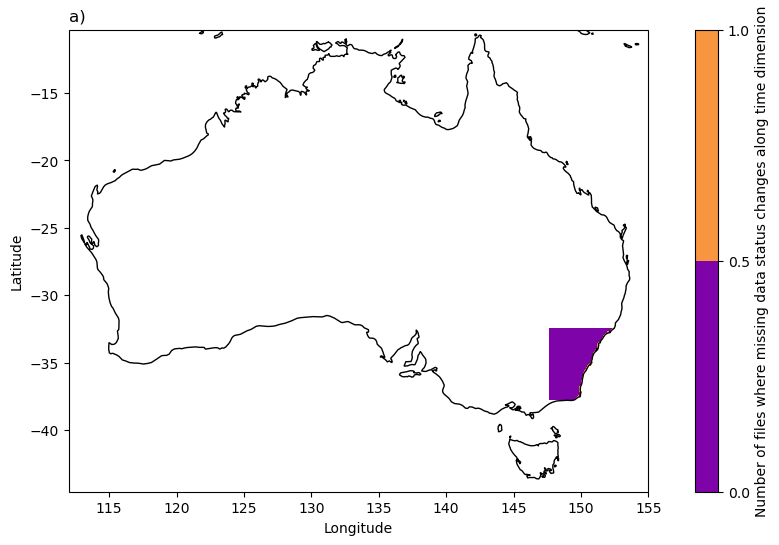

In [17]:
#(missing_any!=missing_all).sum(dim='file').plot
print('Spatial extent of missing data:')
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
cd=ax.contourf(dataset.lon, dataset.lat, (missing_any!=missing_all).sum(dim='file'),[0,0.5,1],transform=ccrs.PlateCarree(),cmap='plasma')
ax.set_title('a)',loc='left')
ax.set_xticks(np.arange(115,156,5), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-45,-9,5), crs=ccrs.PlateCarree())
ax.set_extent([112,155,-42.5,-10.3])
ax.coastlines()
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.colorbar(cd,label='Number of files where missing data status changes along time dimension')
#plt.savefig('missing_data_mismatch_TAS.pdf',bbox_inches='tight')
#plt.savefig('missing_data_mismatch_TAS.png',dpi=600,bbox_inches='tight')
plt.show()

Spatial extent of missing data:


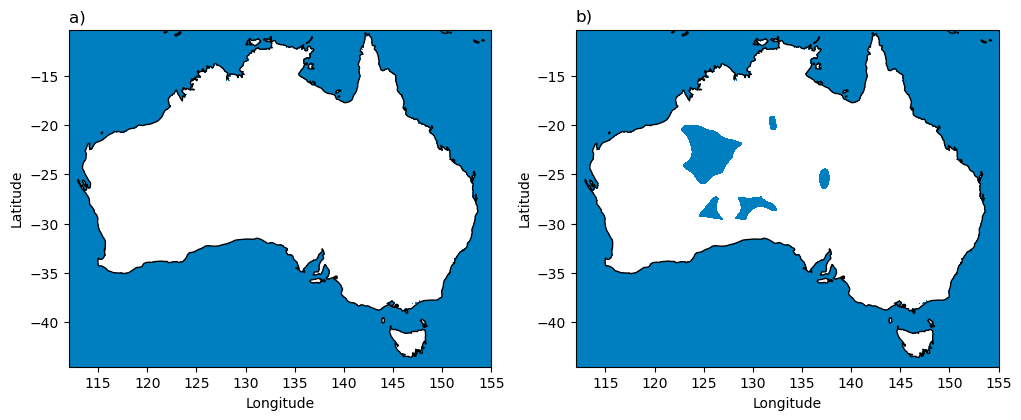

In [89]:
print('Spatial extent of missing data:')
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
cd=ax.contourf(dataset.lon, dataset.lat, dataset['rsds'].isnull().any(dim='time'),[0.9,1],transform=ccrs.PlateCarree(),cmap='winter')
ax.set_title('a)',loc='left')
ax.set_xticks(np.arange(115,156,5), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-45,-9,5), crs=ccrs.PlateCarree())
ax.set_extent([112,155,-42.5,-10.3])
ax.coastlines()
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())
cd=ax.contourf(dataset_a.lon, dataset_a.lat, dataset_a['pr'].isnull().any(dim='time'),[0.9,1],transform=ccrs.PlateCarree(),cmap='winter')
ax.set_title('b)',loc='left')
ax.set_xticks(np.arange(115,156,5), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-45,-9,5), crs=ccrs.PlateCarree())
ax.set_extent([112,155,-42.5,-10.3])
ax.coastlines()
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
#plt.colorbar(cd,label='Proportion of NaN')
#plt.savefig('missing_data.pdf',bbox_inches='tight')
#plt.savefig('missing_data.png',dpi=600,bbox_inches='tight')
plt.show()


In [12]:
from dask.diagnostics import ProgressBar
pr_files=[filestring for filestring in existing_files if 'tasmax' in filestring]
for n in range(len(pr_files)):
    print(n,len(pr_files))
    dataset=xr.open_dataarray(pr_files[n],chunks='auto')
    # if "height" in dataset.coords:
    #     dataset=dataset.drop_vars('height')
    if n==0:
        pr_mean=dataset.mean(dim=['lat','lon']).data[np.newaxis,:].compute()
        pr_max=dataset.max(dim=['lat','lon']).data[np.newaxis,:].compute()
        pr_min=dataset.min(dim=['lat','lon']).data[np.newaxis,:].compute()
    else:
        pr_mean=np.concatenate([pr_mean,dataset.mean(dim=['lat','lon']).data[np.newaxis,:].compute()])
        pr_max=np.concatenate([pr_max,dataset.max(dim=['lat','lon']).data[np.newaxis,:].compute()])
        pr_min=np.concatenate([pr_min,dataset.min(dim=['lat','lon']).data[np.newaxis,:].compute()])

0 65
1 65
2 65
3 65
4 65
5 65
6 65
7 65
8 65
9 65
10 65
11 65
12 65
13 65
14 65
15 65
16 65
17 65
18 65
19 65
20 65
21 65
22 65
23 65
24 65
25 65
26 65
27 65
28 65
29 65
30 65
31 65
32 65
33 65
34 65
35 65
36 65
37 65
38 65
39 65
40 65
41 65
42 65
43 65
44 65
45 65
46 65
47 65
48 65
49 65
50 65
51 65
52 65
53 65
54 65
55 65
56 65
57 65
58 65
59 65
60 65
61 65
62 65
63 65
64 65


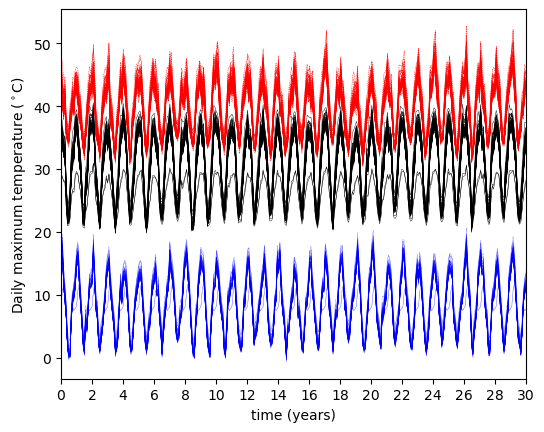

In [17]:
fig = plt.figure(figsize=(.75*8, .75*6.4))
ax = fig.add_subplot(1, 1, 1)
ax.plot(pr_mean[0:3].T,'k-',lw=.3)
ax.plot(pr_max[0:3].T,'r--',lw=.3)
ax.plot(pr_min[0:3].T,'b:',lw=.3)
ax.plot(pr_mean[5:].T,'k-',lw=.3)
ax.plot(pr_max[5:].T,'r--',lw=.3)
ax.plot(pr_min[5:].T,'b:',lw=.3)
# ax.plot(pr_mean.T,'k-',lw=.3)
# ax.plot(pr_max.T,'r-',lw=.3)
# ax.plot(pr_min.T,'b-',lw=.3)
#ax.fill_between(dataset.indexes['time'].to_datetimeindex(),dataset['tasmin'].min(dim=['lat','lon']),dataset['tasmin'].max(dim=['lat','lon']),color='red',alpha=0.25,label='range')
ax.set_ylabel(r'Daily maximum temperature ($^\circ$C)')
#ax.set_yscale('log')
ax.set_xlabel(r'time (years)')
#ax.set_ylim([0,400])
ax.set_xlim([0,359])
ax.set_xticks(np.linspace(0,359,16),np.arange(0,31,2))
plt.savefig('monthly_tasmax_noCESM1.png',bbox_inches='tight',dpi=300)
plt.show()

In [117]:
pr_files

['/g/data/wp00/data/QQ-CMIP5/AgDataShop/AUS_averages/tasmax_CanESM2_rcp26_r1i1p1_CSIRO-QQS-AGCD-1981-2010_day_wrt_1986-2005_2016-2045-monthly-mean.nc',
 '/g/data/wp00/data/QQ-CMIP5/AgDataShop/AUS_averages/tasmax_CanESM2_rcp26_r1i1p1_CSIRO-QQS-AGCD-1981-2010_day_wrt_1986-2005_2036-2065-monthly-mean.nc',
 '/g/data/wp00/data/QQ-CMIP5/AgDataShop/AUS_averages/tasmax_CanESM2_rcp26_r1i1p1_CSIRO-QQS-AGCD-1981-2010_day_wrt_1986-2005_2056-2085-monthly-mean.nc',
 '/g/data/wp00/data/QQ-CMIP5/AgDataShop/AUS_averages/tasmax_CESM1-CAM5_rcp26_r1i1p1_CSIRO-QQS-AGCD-1981-2010_day_wrt_1986-2005_2016-2045-monthly-mean.nc',
 '/g/data/wp00/data/QQ-CMIP5/AgDataShop/AUS_averages/tasmax_CESM1-CAM5_rcp26_r1i1p1_CSIRO-QQS-AGCD-1981-2010_day_wrt_1986-2005_2056-2085-monthly-mean.nc',
 '/g/data/wp00/data/QQ-CMIP5/AgDataShop/AUS_averages/tasmax_CNRM-CM5_rcp26_r1i1p1_CSIRO-QQS-AGCD-1981-2010_day_wrt_1986-2005_2016-2045-monthly-mean.nc',
 '/g/data/wp00/data/QQ-CMIP5/AgDataShop/AUS_averages/tasmax_CNRM-CM5_rcp26_r1i1p1

In [3]:
input_file=xr.open_dataset('/g/data/wp00/data/QQ-CMIP5/AgDataShop/AUS_daily/tasmax_NorESM1-M_rcp45_r1i1p1_CSIRO-QQS-AGCD-1981-2010_day_wrt_1986-2005_2056-2085-daily-mean.nc',chunks='auto')
input_data=input_file['tasmax']
input_file.time

0.3.0


<xarray.DataArray 'time' (time: 10950)>
array([cftime.DatetimeNoLeap(2056, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2056, 1, 2, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2056, 1, 3, 0, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(2085, 12, 29, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2085, 12, 30, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2085, 12, 31, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
    height   float64 ...
  * time     (time) object 2056-01-01 00:00:00 ... 2085-12-31 00:00:00
Attributes:
    axis:           T
    long_name:      time
    standard_name:  time

In [119]:
np.isnan(input_data.data.flatten()).sum().compute()

112332240

This checks the percentage of NaNs in the data, and the spatial distribution of missing data.

Total non-missing count: 99990360
Total count: 212322600
Percentage of data missing values:  52.906398094220776% 

Spatial extent of missing data:


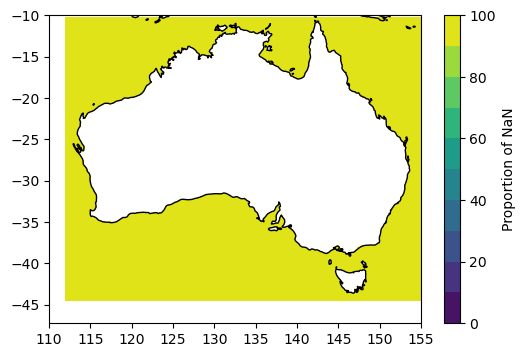


Temporal extent of missing data:


TypeError: float() argument must be a string or a real number, not 'cftime._cftime.DatetimeNoLeap'

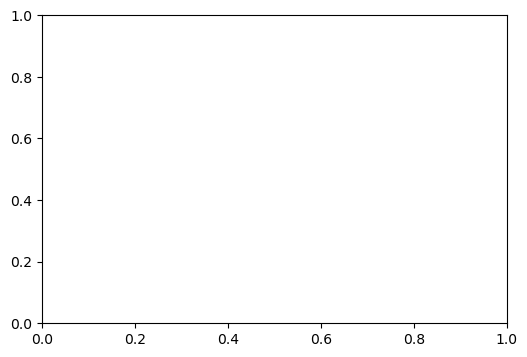

In [120]:
nan_removed_data=input_data.data.flatten()[~np.isnan(input_data.data.flatten())]
nonanlen=len(nan_removed_data.compute())
print('Total non-missing count: '+str(len(nan_removed_data.compute())))
print('Total count: '+str(len(input_data.data.flatten())))
print('Percentage of data missing values:  '+str(100*(1-nonanlen/len(input_data.data.flatten())))+'% \n')

print('Spatial extent of missing data:')
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
cd=ax.contourf(input_data.lon, input_data.lat, 100*np.isnan(input_data).mean(dim='time').where(np.isnan(input_data).mean(dim='time')>0).compute(),np.arange(0,101,10),transform=ccrs.PlateCarree())
ax.set_xticks(np.arange(110,156,5), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-45,-9,5), crs=ccrs.PlateCarree())
ax.set_extent([110,155,-45,-10])
ax.coastlines()
plt.colorbar(cd,label='Proportion of NaN')
plt.show()

print('\nTemporal extent of missing data:')
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(1, 1, 1)
ax.plot(input_data.time,100*np.isnan(input_data).mean(dim=['lat','lon']))
#ax.set_xticks([cftime.DatetimeNoLeap(year, 1, 1,has_year_zero=True) for year in range(2036, 2067, 2)])
formatter = nc_time_axis.CFTimeFormatter("%Y-%m-%d", "noleap")
ax.xaxis.set_major_formatter(formatter)
ax.set_ylabel('Missing data percentage')
plt.xticks(rotation = 90)
plt.show()

In [30]:
hist,binedges=np.histogram(input_data.data,bins=np.arange(-5,57.1,1),density=True)
with ProgressBar():
    hist=hist.compute()

[########################################] | 100% Completed | 127.60 s


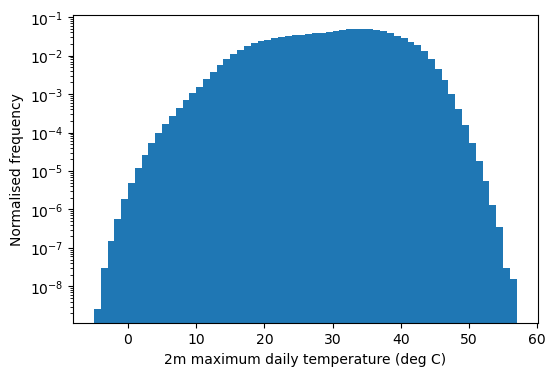

In [35]:
fig = plt.figure(figsize=(6, 4))
gs = fig.add_gridspec(2, 1,height_ratios=(1, 19),bottom=0.1, top=0.9, wspace=0.05, hspace=0.05)
ax = fig.add_subplot(111)
ax.bar((binedges[1:]+binedges[:-1])/2,hist,width=1)
ax.set_ylabel('Normalised frequency')
ax.set_xlabel('2m maximum daily temperature (deg C)')
ax.set_yscale('log')
#plt.savefig('tasmax_NorESM1-M_rcp45_r1i1p1_CSIRO-QQS-AGCD-1981-2010_day_wrt_1986-2005_2056-2085_histo_zoom.png',bbox_inches='tight',dpi=300)
plt.show()

Below is a histogram of all data, with dashed lines representing the WMO observation limits for air temperature (-90 to 70 Celcius). Underneath that is a a boxplot with the 1st, median and 3rd quartiles marked, and the whiskers being an estimate of range extending 1.5 times the interquatile range either side of the box (unless the maximum/minimum values of the data are within this range).

A similar image constrained to the range of the data is also provided.

Finally, the spatial distribution of the region above/below the estimated spread is plotted.

In [ ]:
input_data=input_file['tasmax']

fig = plt.figure(figsize=(6, 4))
gs = fig.add_gridspec(2, 1,height_ratios=(1, 19),bottom=0.1, top=0.9, wspace=0.05, hspace=0.05)
ax = fig.add_subplot(gs[1])
n, bins, patches = ax.hist(input_data.data.flatten()[~np.isnan(input_data.data.flatten())],np.arange(-150,100.1,1),density=True)
ax.axvline(x=-90,color='r',ls='--')
ax.axvline(x=70,color='r',ls='--')
ax.set_ylabel('Normalised frequency')
ax.set_xlabel('2m maximum daily temperature (deg C)')
ax_bp = fig.add_subplot(gs[0],sharex=ax)
ax_bp.boxplot(input_data.data.flatten()[~np.isnan(input_data.data.flatten())],False,"",whis=1.5,vert=False,widths=0.5,autorange=False)
ax_bp.set_axis_off()
#plt.savefig('/g/data/dk7/mjk563/histo.png',bbox_inches='tight',dpi=300)
plt.show()

fig = plt.figure(figsize=(6, 4))
gs = fig.add_gridspec(2, 1,height_ratios=(1, 19),bottom=0.1, top=0.9, wspace=0.05, hspace=0.05)
ax = fig.add_subplot(gs[1])
n, bins, patches = ax.hist(input_data.data.flatten()[~np.isnan(input_data.data.flatten())],np.arange(np.floor(np.nanmin(input_data.data)),np.ceil(np.nanmax(input_data.data))+0.1,1),density=True)
ax.axvline(x=-90,color='r',ls='--')
ax.axvline(x=70,color='r',ls='--')
ax.set_ylabel('Normalised frequency')
ax.set_xlabel('2m maximum daily temperature (deg C)')
ax.set_xlim([np.floor(np.nanmin(input_data.data)),np.ceil(np.nanmax(input_data.data))])
ax_bp = fig.add_subplot(gs[0],sharex=ax)
ax_bp.boxplot(input_data.data.flatten()[~np.isnan(input_data.data.flatten())],False,"",whis=1.5,vert=False,widths=0.5,autorange=False)
ax_bp.set_axis_off()
plt.savefig('tasmax_NorESM1-M_rcp45_r1i1p1_CSIRO-QQS-AGCD-1981-2010_day_wrt_1986-2005_2056-2085_histo_zoom.png',bbox_inches='tight',dpi=300)
plt.show()

q3=input_data.quantile(q=.75)
q1=input_data.quantile(q=.25)
est_min=q1-1.25*(q3-q1)
est_max=q3+1.25*(q3-q1)

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
cd=ax.contourf(input_data.lon, input_data.lat, 100*(input_data<est_min).mean(dim='time').where((input_data<est_min).mean(dim='time')>0),np.arange(0,100.01,10),transform=ccrs.PlateCarree())
ax.set_xticks(np.arange(110,156,5), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-45,-9,5), crs=ccrs.PlateCarree())
ax.set_extent([110,155,-45,-10])
ax.coastlines()
plt.colorbar(cd,label='Percentage of data below estimated min')
plt.show()

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
cd=ax.contourf(input_data.lon, input_data.lat, 100*(input_data>est_max).mean(dim='time').where((input_data>est_max).mean(dim='time')>0),np.arange(0,100.01,10),transform=ccrs.PlateCarree())
ax.set_xticks(np.arange(110,156,5), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-45,-9,5), crs=ccrs.PlateCarree())
ax.set_extent([110,155,-45,-10])
ax.coastlines()
plt.colorbar(cd,label='Percentage of data above estimated max')
plt.show()

The below checks if the coordinate axes are evenly spaced.

In [ ]:
import random

existing_files.sort()
for m in range(256,len(existing_files)):
    print(m)
    filein=existing_files[m]
    inputarray=xr.open_dataarray(filein)
    for n in range(2):
        ts=random.randint(0,len(inputarray.time)-1)
        inputarray[ts].plot()
        plt.savefig('/g/data/wp00/users/mjk563/qaqc_plots/'+filein[48:-3]+'.snapshot'+str(n)+'.png',bbox_inches='tight',dpi=300)
        plt.close()

256
0.3.0
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
